# Curse of Dimensionality

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

Distance calculations are strongly dependent on the amount of dimensions in the dataset. For example, when using the standard euclidean distance, `L2`, in two dimensions, this is given by

$$
\Delta_{L2} = \sqrt{\delta x^2 + \delta y^2}
$$

In higher dimensions, this dinstance metric becomes less useful as D increases. This is also illustrated in the following paper: [ArXiV - Interpreting the Curse of Dimensionality from Distance Concentration and Manifold Effect](https://arxiv.org/abs/2401.00422v3).

In higher dimensional spaces, the data becomes increasingly sparse (lower density), which makes the distance calculation above perform worse. The intuition behind this is that since the datapoints are all very far from one-another (relatively speaking), the individual distances are not discriminative enough anymore to use in an ML algorithm.

One solution for this is to use another distance metric, for example the `L1` metric, also know as the Manhattan distance because it is similar to how distances are calculated in city blocks

$$
\Delta_{L1} = | \delta x | + |\delta y |
$$

But there are many other distance metrics possible, like the cosine (or the closely related dot-product) distance, or the jaccard (set similarity) distance, which are both often used in NLP.

Another option is to apply dimensionality reduction, like PCA, on the dataset before applying an ML algorithm.

## Demonstration

Below we plot a unit circle centered around (0, 0).

Let's now assume that our data is standard scaled, meaning the mean is at (0, 0) and the standard deviation is (1, 1). When we use the L2 norm as distance metric we will assign the same distance to each point on a circle centered at (0, 0) for each radius r.

If we now wanted to classify datapoints, the points outside this circle would be harder to classify since they are seen as farther away. The percentage of space that falls outside the circle is 21%.

(When we instead use the Manhattan distance (or, L1 norm) we are more sensitive to the entire volume, as each corner of the square area is equidistant)

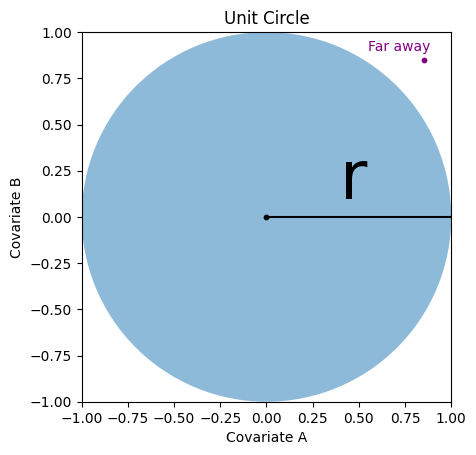

In [5]:
def make_circle(point=False):
    fig = plt.gcf()
    ax = fig.add_subplot(111, aspect='equal')
    fig.gca().add_artist(plt.Circle((0,0),1,alpha=.5))
    ax.scatter(0,0,s=10,color="black")
    ax.plot(np.linspace(0,1,100),np.zeros(100),color="black")
    ax.text(.4,.1,"r",size=48)
    ax.set_xlim(left=-1,right=1)
    ax.set_ylim(bottom=-1,top=1)
    plt.xlabel("Covariate A")
    plt.ylabel("Covariate B")
    plt.title("Unit Circle")
    
    if point:
        ax.text(.55,.9,"Far away",color="purple")
        ax.scatter(.85,.85,s=10,color="purple")
    else: 
        plt.show()
    
make_circle(True)

When we check this for a 3-dimensional volume, the ratio of space is even lower; 48% of the cube lies outside the sphere made up of equidistant L2 points.

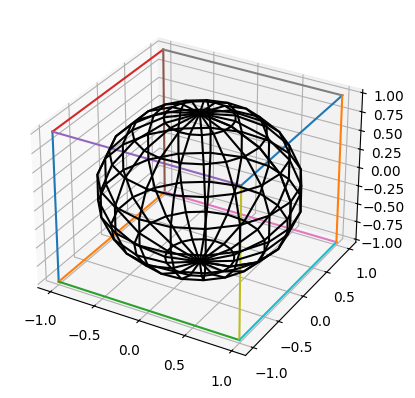

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
#ax.set_aspect("equal")

# Draw cube
r = [-1, 1]
for s, e in combinations(np.array(list(product(r,r,r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s,e))

# Draw sphere on same axis 
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="black");

## Generalising to D dimensions

Now, when we want to generalise this to more dimensions we can use a randomly sampled dataset and simply calculate the distances. Then we can see that for higher dimensions the filling factor of a single ball inside a cubic volume drastically decreases with D.

Data distribution becomes increasingly sparse. A way to think about this is to divide the entire space up in unit cubes (or whatever similar analog in D-dimensions). Then each datapoint will only fall in a single cube, but there are much more of these cubes available. So the ratio of datapoints to volume goes down quickly.

Some example for low-D, small environments:

- 1D limited to $[-5, 5]$ -> 5 datapoints -> There are $10$ line sections, so the average density is 5/10 = 0.5
- 2D limited to $[-5, 5]^2$ -> 5 datapoints -> There are $10x10$ square sections, so the average density is 5/100 = 0.05 
- 3D limited to $[-5, 5]^3$ -> 5 datapoints -> There are $10x10x10$ cubic sections, so the average density is 5/1000 = 0.005 

So again an illustration on how quickly this falls off with dimension.

In [25]:
def L2_dist(x: np.ndarray) -> float:
    return np.sqrt((x**2).sum(axis=1))

def inside_L2(x: np.ndarray) -> bool:
    return L2_dist(x) < 1

def filling_factor(D: int, n_samples: int = 10**4) -> float:
    return inside_L2(np.random.sample((n_samples, D))).mean()

In [28]:
dims = range(2, 15)
pcts = [filling_factor(D) for D in dims]

for dim, pct in zip(dims, pcts):
    print(f"For D={dim}, the filling factor of a single ball in a cube is {pct*100:.2f}%")

For D=2, the filling factor of a single ball in a cube is 78.80%
For D=3, the filling factor of a single ball in a cube is 51.68%
For D=4, the filling factor of a single ball in a cube is 30.21%
For D=5, the filling factor of a single ball in a cube is 16.51%
For D=6, the filling factor of a single ball in a cube is 8.44%
For D=7, the filling factor of a single ball in a cube is 3.74%
For D=8, the filling factor of a single ball in a cube is 1.43%
For D=9, the filling factor of a single ball in a cube is 0.61%
For D=10, the filling factor of a single ball in a cube is 0.23%
For D=11, the filling factor of a single ball in a cube is 0.07%
For D=12, the filling factor of a single ball in a cube is 0.06%
For D=13, the filling factor of a single ball in a cube is 0.02%
For D=14, the filling factor of a single ball in a cube is 0.01%


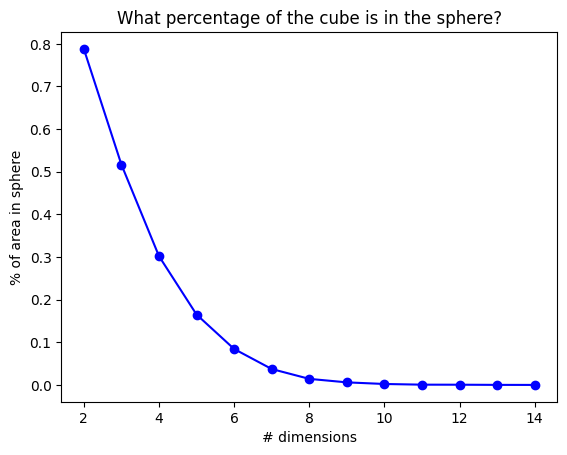

In [31]:
plt.plot(dims, pcts, 'bo-')
plt.xlabel("# dimensions")
plt.ylabel("% of area in sphere")
plt.title("What percentage of the cube is in the sphere?")
plt.show()

## Distance from the center of a cube to the nearest point

Below we generate random points in a cube for different amounts of D. Since in higher dimensions there are more options for the point to be far away from the center than to be close to the center, we can clearly see this effect when plotting the distribution.

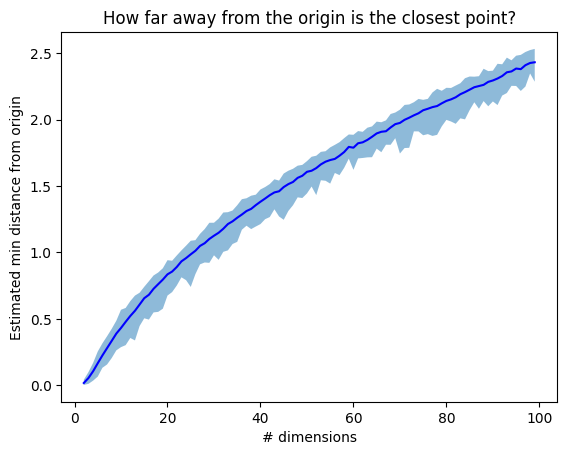

In [33]:
def get_min_distance(dimension, sample_size=10**3):
    ''' Sample some random points and find the closet 
    of those random points to the center of the data '''
    points = np.random.sample((sample_size,dimension))-.5   # centering our data
    return np.min(L2_dist(points))

def estimate_closest(dimension):
    ''' For a given dimension, take a random sample in that dimension and then find 
        that sample's closest point to the center of the data. 
        Repeat 100 times for the given dimension and return the min/max/mean 
        of the distance for the nearest point. '''
    data = np.array([get_min_distance(dimension) for _ in range(100)])
    return data.mean(), data.min(), data.max()

# Calculate for dimensions 2-100
dims = range(2,100)
min_distance_data = np.array(list(map(estimate_closest,dims)))

# Plot the min/max/mean of the closest point for each dimension using sampling 

plt.plot(dims,min_distance_data[:,0], color='blue')
plt.fill_between(dims, min_distance_data[:,1], min_distance_data[:,2],alpha=.5)
plt.xlabel("# dimensions")
plt.ylabel("Estimated min distance from origin")
plt.title("How far away from the origin is the closest point?"); 

## Solutions to the Curse Of Dimensionality

As alluded to in the intro, there are some options to remedy high dimensional datasets. The most common are:
- Feature selection, manually reducing the amount of dimensions by choosing which features to use.
- Feature extraction/dimensionality reduction

Below we look at model performance with high-dimensional data vs a lower-dimension alternative.

First, build a model with only 2 features as a baseline.

In [36]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [37]:
DT =  DecisionTreeClassifier()
DT.fit(X_train, y_train)
score = DT.score(X_test, y_test)
print("Score from two-feature classifier: ", score)

Score from two-feature classifier:  0.875


Then we can also try the same with a 200-dimension version.

In [51]:
X, y = make_classification(n_features=200, n_redundant=0, n_informative=200,
                           random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [53]:
DT =  DecisionTreeClassifier()
DT.fit(X_train, y_train)
score = DT.score(X_test, y_test)
print("Score from 200-feature classifier: ", score)

Score from 200-feature classifier:  0.5


Finally, we can show this effect datasets with increasing amounts of features. From this we can see that the accuracy is actually highly unpredictable considering the amount of features. So it is unclear whether adding or removing features will actually improve model performance.

In this case, no features are redundant, so in practice this issue might be even larger.

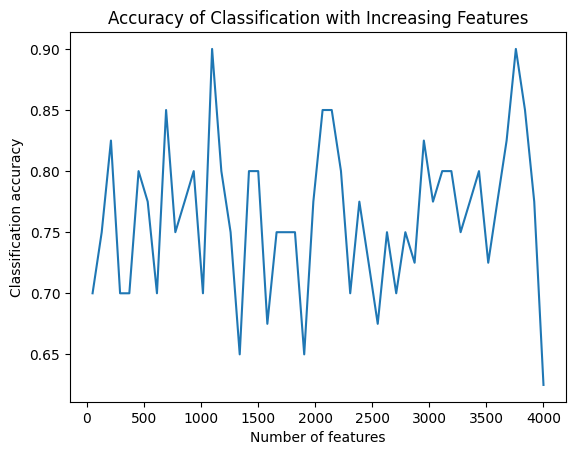

In [56]:
scores = []
delta = 50
max_features = 4000
n_features = np.linspace(delta, max_features, delta, dtype=int)

for n in n_features:
    
    X, y = make_classification(
        n_features=n, 
        n_redundant=0,
        random_state=1, 
        n_clusters_per_class=1, 
        n_classes=3)
    
    # Randomise input data
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
    
    DT =  DecisionTreeClassifier()
    DT.fit(X_train, y_train)
    scores.append( DT.score(X_test, y_test) )
    
plt.plot(n_features, scores)
plt.title("Accuracy of Classification with Increasing Features")
plt.xlabel("Number of features")
plt.ylabel("Classification accuracy");